# Exploring ATA6 embedding using descriptions in ATA Master List 


## Todo: 
1. Lowercase everything. Roberta is case-sensitive. 
1. Use a domain-adapted roberta model. 
1. Combine Component and Location label_values whenever possible 
1. Confirm the accuracy of the ATA master list. 
    1. How to doel with differences across AC model? 


In [1]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 13.7 MB/s eta 0:00:00


In [2]:
import re 
from pathlib import Path

import numpy as np
import pandas as pd 
from transformers import RobertaModel, RobertaTokenizer
from datasets import Dataset
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import torch 
from umap import UMAP
import faiss

In [3]:
DATA_PATH = Path(r'../input/737-ata-4plus')
data_file = '2023-03-31_737_ata-master-list-4plus.csv'

col_text = 'Title'

df = pd.read_csv(DATA_PATH.joinpath(data_file))

In [4]:
data = Dataset.from_pandas(df)

In [5]:
model_ckpt = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_ckpt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def tokenize_batch(batch): 
    return tokenizer(batch[col_text], padding=True, truncation=True)

In [7]:
# Example with first two texts: 
tokenize_batch(data[:2])

{'input_ids': [[0, 7613, 8167, 45119, 230, 4546, 26896, 2, 1, 1, 1, 1, 1], [0, 7613, 8167, 45119, 230, 4546, 26896, 23464, 22980, 12435, 6324, 19569, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [8]:
# Encoding the full dataset
data_encoded = data.map(tokenize_batch, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
data_encoded

Dataset({
    features: ['ATA', 'Title', 'input_ids', 'attention_mask'],
    num_rows: 480
})

In [10]:
def extract_hidden_states(batch): 
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad(): 
        last_hidden_state = model(**inputs).last_hidden_state
    return {'cls_hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

In [11]:
data_encoded.set_format('torch', columns=['input_ids', 'attention_mask'])

In [12]:
data_hidden_state = data_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
data_hidden_state

Dataset({
    features: ['ATA', 'Title', 'input_ids', 'attention_mask', 'cls_hidden_state'],
    num_rows: 480
})

In [14]:
data_hidden_state['cls_hidden_state'].shape

torch.Size([480, 768])

In [15]:
X = np.array(data_hidden_state['cls_hidden_state'])
X.shape

(480, 768)

In [16]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.043337,0.072313,-0.020343,-0.102101,0.056351,-0.090035,-0.045033,-0.008111,0.056988,-0.060410,...,0.040397,0.000103,-0.034320,-0.083389,0.023965,0.128978,0.066766,-0.036580,-0.057320,-0.028288
1,-0.030184,0.065612,-0.022094,-0.103319,0.059147,-0.112213,-0.056607,-0.009831,0.052056,-0.056667,...,0.031662,-0.007099,-0.043329,-0.091752,0.013569,0.128143,0.061553,-0.050738,-0.048170,-0.010134
2,-0.037469,0.068109,-0.020356,-0.095122,0.057912,-0.081640,-0.047427,-0.011610,0.061793,-0.054412,...,0.040711,-0.012637,-0.031732,-0.078692,0.020380,0.127667,0.072776,-0.045248,-0.045891,-0.003501
3,-0.039911,0.063098,-0.031918,-0.088520,0.082917,-0.067343,-0.049897,-0.013888,0.050750,-0.062029,...,0.030143,-0.016558,-0.029927,-0.088950,0.029555,0.125436,0.069403,-0.043279,-0.054016,-0.010321
4,-0.051974,0.062987,-0.040034,-0.084519,0.058721,-0.111527,-0.048928,-0.036384,0.054467,-0.052409,...,0.031693,-0.009302,-0.036366,-0.089695,0.013896,0.123565,0.082726,-0.045615,-0.046736,-0.017238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-0.037788,0.077748,-0.016406,-0.106750,0.071234,-0.100881,-0.053556,0.003826,0.057548,-0.067342,...,0.018085,-0.001806,-0.053124,-0.089417,-0.005120,0.131739,0.083909,-0.063713,-0.066491,-0.013672
476,-0.035686,0.065790,-0.023826,-0.092666,0.068696,-0.100354,-0.062453,-0.000258,0.047921,-0.064668,...,0.011839,-0.006716,-0.047534,-0.105154,-0.013823,0.129572,0.085534,-0.065737,-0.067294,-0.013190
477,-0.031589,0.079478,-0.029845,-0.094104,0.066168,-0.103227,-0.042377,-0.001380,0.058231,-0.073537,...,0.034539,0.001434,-0.048477,-0.093479,-0.015042,0.123939,0.072668,-0.058130,-0.071653,-0.000699
478,-0.027790,0.081390,-0.027330,-0.107812,0.083266,-0.098255,-0.048943,-0.002449,0.054963,-0.068886,...,0.025699,0.000735,-0.049783,-0.096074,0.001775,0.121580,0.075951,-0.053483,-0.067647,-0.013358


In [17]:
y = np.array([ata[:2] for ata in data_hidden_state['ATA']])

## Visualization with UMAP

In [18]:
X_scaled = MinMaxScaler().fit_transform(X)

mapper = UMAP(n_components=2, metric='cosine', random_state=2023).fit(X_scaled)

mapper

UMAP(angular_rp_forest=True, metric='cosine', random_state=2023, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [19]:
df_umap_2d = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_umap_2d['label'] = y

In [20]:
df_umap_2d

,X,Y,label
0,5.934539,6.497276,27
1,7.999505,2.751323,27
2,5.676851,6.784760,27
3,6.013988,6.621727,27
4,5.843820,6.496277,27
...,...,...,...
475,6.280848,6.042000,52
476,6.205682,5.613698,52
477,5.400972,5.544036,52
478,5.765224,5.992949,52


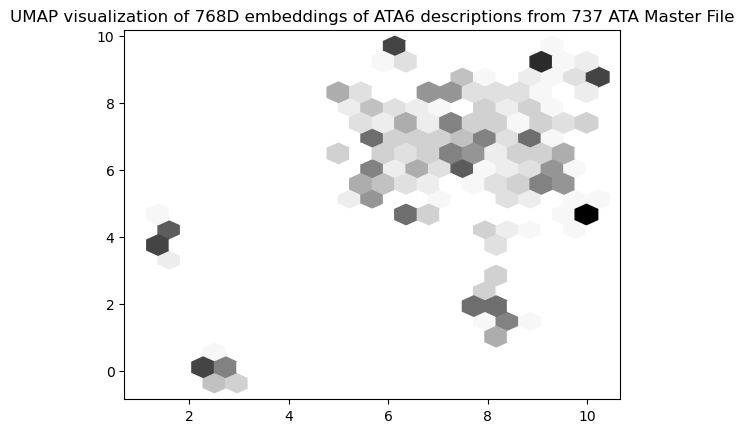

In [21]:
txt = 'UMAP visualization of 768D embeddings of ATA6 descriptions from 737 ATA Master File'
fig, ax = plt.subplots()
ax.hexbin(
    df_umap_2d['X'],
    df_umap_2d['Y'],
    cmap="Greys", 
    gridsize=20
)
ax.set_title(txt)
fig.show()

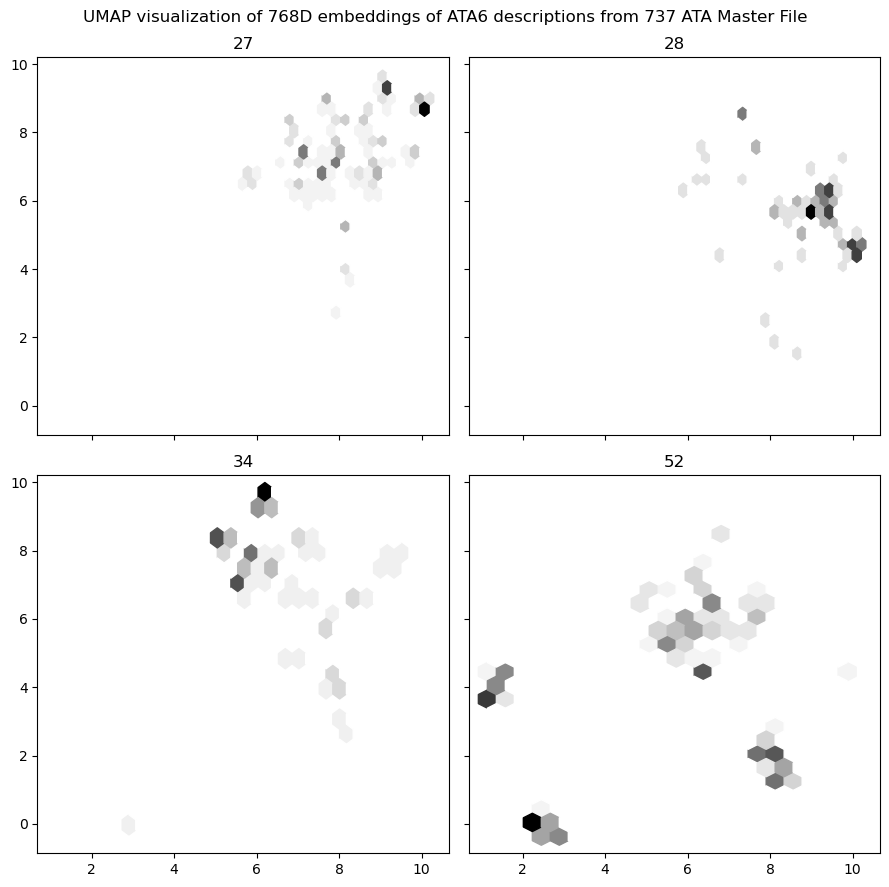

In [22]:
txt = 'UMAP visualization of 768D embeddings of ATA6 descriptions from 737 ATA Master File'
fig, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)
axes = axes.flatten()
labels = df_umap_2d['label'].unique()
cmap = "Greys"

for i, label in enumerate(labels): 
    df_umap_sub = df_umap_2d.query('label==@label')
    axes[i].hexbin(
        df_umap_sub['X'], 
        df_umap_sub['Y'], 
        cmap=cmap, 
        gridsize=20
    )
    axes[i].set_title(label)
plt.suptitle(txt)
plt.tight_layout()
plt.show()
    

## Nearest-neighbour lookups 

In [23]:
data_hidden_state.add_faiss_index(column='cls_hidden_state')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['ATA', 'Title', 'input_ids', 'attention_mask', 'cls_hidden_state'],
    num_rows: 480
})

In [24]:
# these inputs are NER labels 
query_list = [
    'GPS', 'EXIT DOOR', 'SLAT CBS', 'FUEL SPAR VALVE', 'GLOBAL POSITIONING SYSTEM', 'GPS SENSOR UNIT', 
    'NDB', 'NAVIGATION DATABASE', 'GLOBAL POSITIONING SYSTEM (GPS)', 'ECS ACCESS DOORS', 'AIRSTAIR', 
    'IFF ANTENNA', 'RADAR SYS', 'radar sys', 'FSEU', 'DOOR PRESSURE SEAL', 'ACCESS DOOR', 'AMBER LIGHT', 
    'FUEL', 'TCAS', 'PITOT COVERS', 'STANDBY AIRSPEED INDICATOR', 'STNDBY AIRSPEED IND',
    '201504R10SPEEDBRAKE AUTOSTOW ACTUATOR AUTOMATIC', 'AIRSTAIRS', 'airstairs', 'FUEL SCAVENGE SYSTEMS'
]

for idx, query in enumerate(query_list): 
    print(f'\nInput number: {idx} ------------')
    print(f'Input text: {query}')
    
    query_encoding = tokenizer(query, return_tensors='pt', truncation=True, padding=True)
    inputs = {k:v.to(device) for k,v in query_encoding.items()}

    query_cls_embedding = model(**inputs).last_hidden_state[:, 0, :].detach().cpu().numpy()
    
    scores, retrieved_examples = data_hidden_state.get_nearest_examples('cls_hidden_state', query_cls_embedding, k=5)
    
    for n in range(4): 
        tokens = tokenizer.convert_ids_to_tokens(retrieved_examples['input_ids'][n])
        print(re.sub('<pad>', '', tokenizer.convert_tokens_to_string(tokens)))


Input number: 0 ------------
Input text: GPS
<s>CHIME MODULE</s>
<s>SPAR VALVE</s>
<s>KEYPAD</s>
<s>DOOR LATCH</s>

Input number: 1 ------------
Input text: EXIT DOOR
<s>FLIGHT COMPARTMENT DOOR</s>
<s>FORWARD ACCESS DOOR</s>
<s>CREW DOOR SEALS</s>
<s>ELECTRONIC EQUIPMENT ACCESS DOOR</s>

Input number: 2 ------------
Input text: SLAT CBS
<s>DOOR LATCH</s>
<s>STATIC PORT</s>
<s>LIGHT SEALS</s>
<s>SPAR VALVE</s>

Input number: 3 ------------
Input text: FUEL SPAR VALVE
<s>SPAR VALVE</s>
<s>FUEL VENT FLOAT VALVE</s>
<s>FUEL CROSSFEED VALVE</s>
<s>DEFUEL VALVE</s>

Input number: 4 ------------
Input text: GLOBAL POSITIONING SYSTEM
<s>HUD SYSTEM COMPUTER</s>
<s>TRAILING EDGE FLAP POSITION INDICATOR</s>
<s>HUD SYSTEM OVERHEAD UNIT</s>
<s>HUD SYSTEM CONTROL PANEL</s>

Input number: 5 ------------
Input text: GPS SENSOR UNIT
<s>GPS SENSOR UNIT</s>
<s>GPS ANTENNA</s>
<s>FMCS COMPUTER UNIT</s>
<s>FQIS DENSITOMETER</s>

Input number: 6 ------------
Input text: NDB
<s>RUDDER</s>
<s>DOOR LATCH</s>
